<img align="center" src="img/course.png" width="800">

# 16720 (B)  Object Tracking in Videos - Assignment 6 - Q2
    Instructor: Kris                          TAs: Wen-Hsuan (Lead), Zen, Yan, Rawal, Paritosh, Qichen

In [3]:
# Libraries

import numpy as np
from scipy.interpolate import RectBivariateSpline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

## Q2: Matthew-Bakers Inverse Compositional Alignment with Affine Matrix

### Q2.1: Implementation (10 PT write-up, 20 PT implementation)
Now we will implement the Matthew-Bakers tracker to alleviate the computational costs of the the Lucas-Kanade tracker, as it only calculates the Hessian and Jacobian once per each video. Write the function with the following function signature:

```
            M = InverseCompositionAffine(It, It1, rect)
```
that computes the optimal local motion represented by a $2x3$ affine transformation matrix $M$ from frame $I_t$ to frame $I_{t+1}$ that minimizes

$$
\begin{gathered}
\mathcal{L}=\sum_{\mathbf{x}}[\mathbf{T}(\mathbf{x})-\mathbf{I}(\mathbf{W}(\mathbf{x} ; \mathbf{p}))]^{2}. 
\end{gathered}
$$

The inputs are structured identically to Q1.2, but you should replace the forward alignment algorithm with the inverse compositional alignment algorithm. You may also find these materials useful: [link](https://www.ri.cmu.edu/pub_files/pub3/baker_simon_2002_3/baker_simon_2002_3.pdf) and [link](https://www.ri.cmu.edu/pub_files/pub3/baker_simon_2003_3/baker_simon_2003_3.pdf).

<span style='color:red'>**Output:**</span> In your write-up: Please include the results of the algorithm on all five videos we have provided along with your code. Compare the results of the Matthew-Bakers Tracker with the previous algorithms you have implemented. How do your algorithms perform on each video? What are the differences of the three algorithms in terms of performance and why do they have those differences? At what point does the algorithm break down and why does this happen?

In [6]:
def InverseCompositionAffine(It, It1, rect, thresh=.025, maxIt=100):
    '''
    Q2.1: Matthew-Bakers Inverse Compositional Alignment with Affine MAtrix
    
      Inputs: 
        It: template image
        It1: Current image
        rect: Current position of the object
        (top left, bottom right coordinates, x1, y1, x2, y2)
        thresh: Stop condition when dp is too small
        maxIt: Maximum number of iterations to run
        
      Outputs:
        M: Affine mtarix (2x3)
    '''
    
    # ----- TODO -----
    # YOUR CODE HERE
        # Set thresholds (you probably want to play around with the values)
    W = np.identity(3)
    dp = np.ones(6)
    p = np.array([1.,0.,0.,0.,1.,0.])
    threshold = thresh
    maxIters = maxIt
    i = 0
    x1, y1, x2, y2 = rect
    
    
    height, width = It.shape
    
    # ----- TODO -----
    # YOUR CODE HERE
    ## image gradient
    gy, gx = np.gradient(It)
    
    intep_y, intep_x = int(y2-y1), int(x2-x1)
    # intep_y, intep_x = 2*(y2-y1), 2*(x2-x1)
    
    y = np.arange(0, height, 1)
    x = np.arange(0, width, 1)
    current_linespace_x = np.linspace(x1, x2, intep_x)
    current_linespace_y = np.linspace(y1, y2, intep_y)
    current_grid_y, current_grid_x = np.meshgrid(current_linespace_y, current_linespace_x)
    
    interpolator_gx = RectBivariateSpline(y, x, gx)
    interpolator_gy = RectBivariateSpline(y, x, gy)
    interpolator_Current = RectBivariateSpline(y, x, It)
    interpolator_Next = RectBivariateSpline(y, x, It1)
    
    Template = interpolator_Current.ev(current_grid_y, current_grid_x)
    Ix = interpolator_gx.ev(current_grid_y, current_grid_x)
    Iy = interpolator_gy.ev(current_grid_y, current_grid_x)
    
    I = np.vstack((Ix.ravel(),Iy.ravel())).T #(N, 2)
    
    jac_W = [np.array([[x, y, 1, 0, 0, 0],[0, 0, 0, x, y, 1]]) \
             for y,x in zip(current_grid_y.ravel(), current_grid_x.ravel())]
    jac_W = np.array(jac_W) #(N, 2, 6)
    
    A = np.einsum("nc, ncp -> np", I, jac_W)
    
    while np.sum(np.square(dp)) > threshold:
        
        # warp the template
        warp_grid_x =  current_grid_x * W[0,0] +  current_grid_y * W[0,1] + W[0,2]
        warp_grid_y =  current_grid_x * W[1,0] +  current_grid_y * W[1,1] + W[1,2]
        
        warp_I = interpolator_Next.ev(warp_grid_y, warp_grid_x)
        
        err = (Template - warp_I).reshape(-1)
        
        dp,_,_,_ = np.linalg.lstsq(A,err,rcond=None)
        dW = np.vstack((dp.reshape(2,3), [0, 0, 1]))
        dW[0,0] +=1; dW[1,1] +=1;
        W = W @(dW)
        p+=dp
    
    W = p.reshape(2,3)
    
    return W

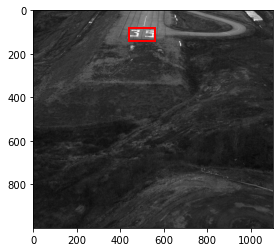

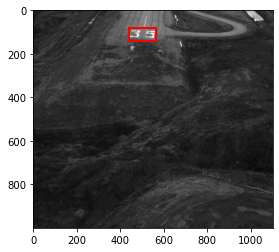

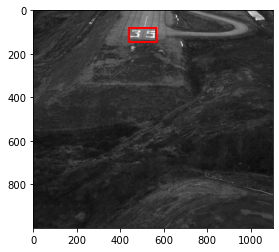

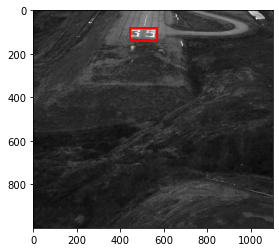

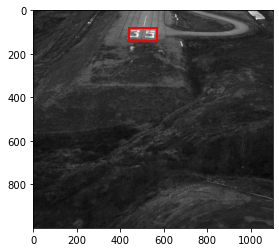

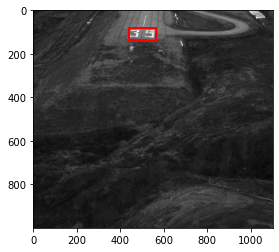

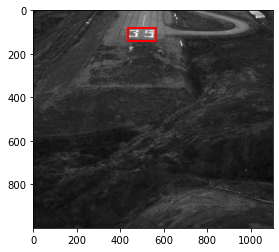

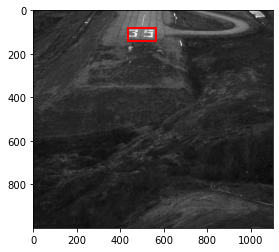

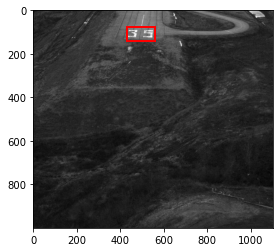

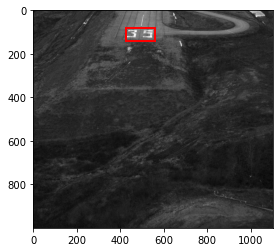

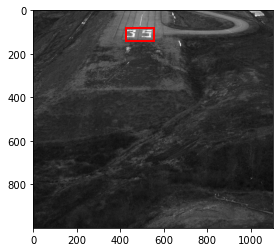

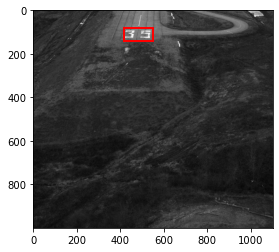

KeyboardInterrupt: 

In [7]:
# Test your algorithm and visualize results!

# Load data
data_name = 'landing' # could choose from (car1, car2, landing, race, ballet)
data = np.load('./data/%s.npy' % data_name)

# obtain the initial rect with format (x1, y1, x2, y2)
if data_name == 'car1':
    initial = np.array([170, 130, 290, 250])
elif data_name == 'car2':
    initial = np.array([59, 116, 145, 151])
elif data_name == 'landing':
    initial = np.array([440, 80, 560, 140])
elif data_name == 'race':
    initial = np.array([170, 270, 300, 370])
elif data_name == 'ballet':
    initial = np.array([700, 210, 775, 300])
else:
    assert False, 'the data name must be one of (car1, car2, landing, race, ballet)'

numFrames = data.shape[2]
w = initial[2] - initial[0]
h = initial[3] - initial[1]

# loop over frames
rects = []
rects.append(initial)

for i in range(numFrames-1):

    It = data[:,:,i]
    It1 = data[:,:,i+1]
    rect = rects[i]

    # run algorithm and collect rects
    M = InverseCompositionAffine(It, It1, rect)
    corners = np.array([[rect[0], rect[1], 1], 
                        [rect[2], rect[3], 1]]).transpose()
    newRect = np.matmul(M, corners).transpose().reshape((4, ))
    rects.append(newRect)

    # Visualize
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.add_patch(patches.Rectangle((rect[0], rect[1]), rect[2]-rect[0]+1, rect[3]-rect[1]+1, linewidth=2, edgecolor='red', fill=False))
    plt.imshow(It1, cmap='gray')
    plt.show()
    ax.clear()

In [ ]:
# For some transparency: we evaluate on multiple frames in a given video starting from the first frame.
# We then compare against the reference implementation and calculate the sum of all differences.
# You should not need to tune anything for the autograding. We pass in the same hyperparameters for you.


### Q2.2: Comparing Your Algorithms (write-up only, 10 PT)
Compare the results of the Matthew-Bakers Tracker with the previous algorithms you have implemented. How do your algorithms perform on each video? What are the differences of the three algorithms in terms of performance and why do we have those differences?  At what point does the algorithm break down and why does this happen?